# Two approaches in dealing with uncertainty
A Bayesian and Frequentist approach to prediction uncertainty. In both cases, I want to define both aleatoric and epistemic uncertainty.

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pymc3 as pm

from functools import partial

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# from scipy import stats

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Generating a dataset

In [14]:
np.random.seed(42)

w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=300, n_tst=150):
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst

y, x, x_tst = load_dataset()

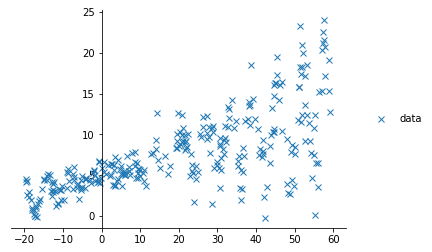

In [15]:
ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.plot(x, y, 'x', label='data')
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

## Scaling the data

In [16]:
ssx = MinMaxScaler()#StandardScaler()
x = ssx.fit_transform(x)

ssy = MinMaxScaler()#StandardScaler()
y = ssy.fit_transform(y.reshape(-1, 1))

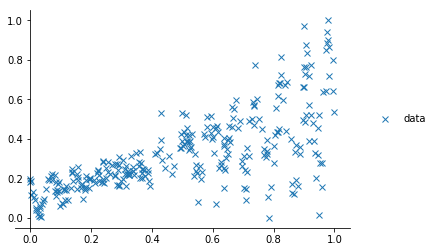

In [17]:
ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.plot(x, y, 'x', label='data')
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

### Customized data generator
but somehow doesn't work and makes model very slow...

In [19]:
# np.random.seed(1)

# w0 = .2
# b0 = .25
# x_range = [-.5, 1]

# def load_dataset(n=150, n_tst=150):
#     def s(x):
#         g = (x - x_range[0]) / (x_range[1] - x_range[0]) / 2.5
#         return .05 + g**2
    
#     x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
#     eps = np.random.randn(n) * s(x) 
#     y = (w0 * x * (1. + np.sin(x)) + b0) + eps
#     x = x[..., np.newaxis]
#     x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
#     x_tst = x_tst[..., np.newaxis]
#     return y, x, x_tst

# y, x, x_tst = load_dataset()

## The Bayesian approach

**Priors**:

$\alpha \sim N(0, 10)$

$\beta \sim N(0, 10)$

Linear Regression: $\mu = \alpha + \beta x$

**Likelihood**: 

$y \sim N(\mu, \sigma)$

**(Extra) Increasing variance**:

$\sigma_{scale} \sim N(0, 10)$

$\sigma_{bias} \sim N^+(10)$

$\sigma = \sigma_{bias} + \sigma_{scale} * x$

As you can see on the plot, the variance increases when x increases. Therefore I model the variance as a softplus method.

## Modelling in PyMC3
Modelling a linear regression with increasing variance. 

In [22]:
with pm.Model():
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 10)
    mu = pm.Deterministic('mu', alpha + beta * x)
    sd_scale = pm.Normal('sd_scale', mu=0, sd=10)
    sd_bias = pm.HalfNormal('sd_bias', sd=10) + 1e-5
    sd = pm.Deterministic('sigma', sd_bias + mu * sd_scale)
    obs = pm.Normal('obs', mu, sd=sd, observed=y)
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_bias, sd_scale, beta, alpha]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:05<00:00, 1793.43draws/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6054235431664662, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9145500120516135, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6646977526208057, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


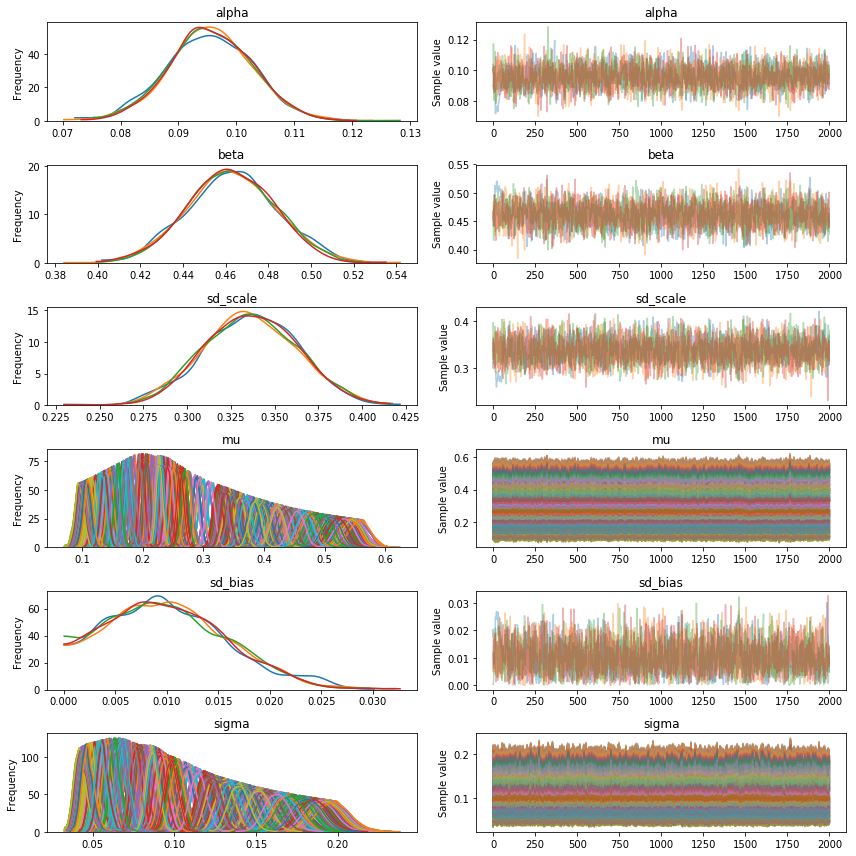

In [23]:
pm.traceplot(trace);

## Postprocessing
Sort and calculate credible intervals (2$ * \sigma$) for visualization

In [24]:
x_ = np.sort(x, axis=0)
mu = (trace['alpha'] + trace['beta'] * x_)
sigma = np.sort(np.transpose(np.squeeze(trace['sigma'], axis=-1)), axis=0)
std_2_plus = mu + 2 * sigma
std_2_min = mu - 2 * sigma

## Plotting median and credible interval (2$*\sigma$)

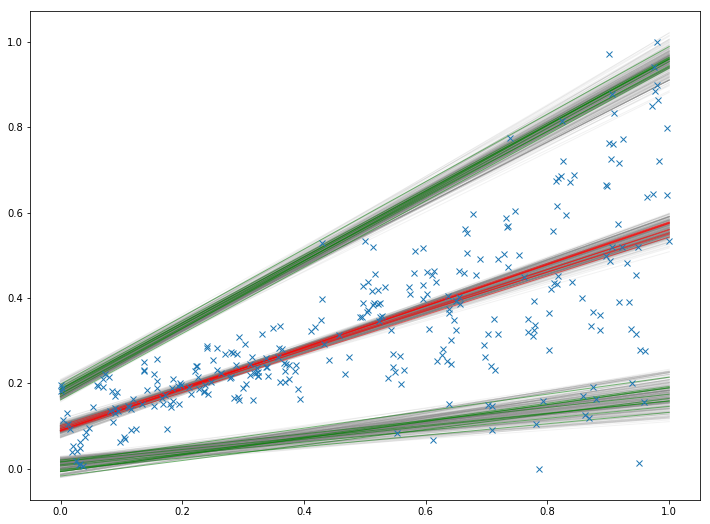

In [25]:
plt.figure(figsize=(12, 9))
n = 300
n_c = 10

plt.plot(x_, (trace['alpha'][:n] + trace['beta'][:n] * x_), alpha=.1, lw=1, c='grey')
plt.plot(x_, std_2_min[:, :n], alpha=.1, lw=1, c='grey')
plt.plot(x_, std_2_plus[:, :n], alpha=.1, lw=1, c='grey')
plt.plot(x_, (trace['alpha'][n:n+n_c] + trace['beta'][n:n+n_c] * x_), alpha=.5, lw=1, c='red')
plt.plot(x_, std_2_min[:, n:n+n_c], alpha=.5, lw=1, c='green')
plt.plot(x_, std_2_plus[:, n:n+n_c], alpha=.5, lw=1, c='green')

plt.plot(x, y, 'x');

## Quantile regression neural network, using MCDropout (in PyTorch)

In [27]:
def QuantileLoss(preds, target, quantiles):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0), f'preds.size:{preds.shape} target.size:{quantiles.shape}'
    assert preds.size(1) == quantiles.shape[0], f'preds.size:{preds.shape} quantiles.shape:{quantiles.shape}'

    def _tilted_loss(q, e):
        return torch.max((q-1) * e, q * e).unsqueeze(1)

    err = target - preds
    losses = [_tilted_loss(q, err[:, i])  # calculate per quantile
              for i, q in enumerate(quantiles)]

    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

class Dropout_hidden_dim(torch.nn.modules.dropout._DropoutNd):
    """ Dropout that masks the (hidden) features equally over a batch """
    def __init__(self, p, dim=1, **kwargs):
        super().__init__(p, **kwargs)
        self.dropout_dim = dim
        
    def forward(self, X):
        mask = torch.autograd.Variable(
            torch.bernoulli(
                X.new(X.size(self.dropout_dim)).fill_(1-self.p)
            )
        )
        return X * mask
    
class DeepQuantileRegression(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.hidden_size = params['hidden_size']
        self.quantiles = params['quantiles']
        self.model = nn.Sequential(
            nn.Linear(params['input_size'], params['hidden_size']),
#             nn.ReLU(),  # when you want to model non-linearities
            Dropout_hidden_dim(params['dropout_p'], dim=params['dropout_dim']),
            nn.Linear(params['hidden_size'], params['hidden_size']),
#             nn.ReLU(),  # when you want to model non-linearities
            Dropout_hidden_dim(params['dropout_p'], dim=params['dropout_dim']),
            nn.Linear(params['hidden_size'], len(params['quantiles']))
        )
    
    def forward(self, X):
        return self.model(X)

    
def get_model(params):
    model = DeepQuantileRegression(params)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    return model, optimizer

## Setting up
- model, model config
- data loader/generator

In [76]:
# QUANTILES = np.linspace(0.1, 0.9, 9)
QUANTILES = np.array([0.025, 0.16, 0.5, 0.84, 0.975])  # -2std, -1std, median, 1std, 2std
params = {
    'input_size': 1,
    'hidden_size': 64,
    'dropout_p': 0.01,
    'dropout_dim': 1,
    'quantiles': QUANTILES,
    'batch_size': 16,
    'epochs': 501,
    'lr': 0.00001
}
model, optim = get_model(params)
criterion = partial(QuantileLoss, quantiles=QUANTILES)

train_ds = TensorDataset(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
train_dl = DataLoader(train_ds, params['batch_size'], shuffle=True)

## Training the model

In [77]:
for epoch in range(params['epochs']):
    for x_batch, y_batch in train_dl:
        model.train()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        model.eval()
        with torch.no_grad():
            x_val, y_val = train_dl.dataset.tensors
            val_loss = criterion(model(x_val), y_val)  # for now same as train set
    
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} \t Loss: {val_loss}")

Epoch: 0 	 Loss: 0.8299574851989746
Epoch: 50 	 Loss: 0.15799172222614288
Epoch: 100 	 Loss: 0.13094262778759003
Epoch: 150 	 Loss: 0.125747948884964
Epoch: 200 	 Loss: 0.12546475231647491
Epoch: 250 	 Loss: 0.12896178662776947
Epoch: 300 	 Loss: 0.12363065034151077
Epoch: 350 	 Loss: 0.1235373467206955
Epoch: 400 	 Loss: 0.14321792125701904
Epoch: 450 	 Loss: 0.12366517633199692
Epoch: 500 	 Loss: 0.12383224815130234


## Check if custom dropout layer works as intendet

In [79]:
with torch.no_grad():
    model.train()
    x_val_test = torch.zeros(x_val.shape)
    preds_test = np.array([model(x_val_test).numpy() for _ in range(1000)])
    
assert np.array_equal(preds_test[:, 0], preds_test[:, 1]) == True  # every row in batch is masked equally
assert np.array_equal(preds_test[0, :], preds_test[1, :]) == False  # every column (hidden feature) is masked randomly per batch

## predict

In [80]:
with torch.no_grad():
    model.train()
    preds = np.array([model(x_val).numpy() for _ in range(1000)])

## Some postprocessing

In [81]:
preds_ = np.swapaxes(np.swapaxes(preds, 0, -1), 0, 1)
preds_.shape
preds.shape, preds_.shape

((1000, 300, 5), (300, 5, 1000))

In [82]:
sorted_index = x_val.argsort(axis=0).flatten()
x_, y_hat = x_val[sorted_index, ...].numpy(), preds_[sorted_index, ...]
x_.shape, y_hat.shape

((300, 1), (300, 5, 1000))

## Plotting median and credible interval (2$*\sigma$)

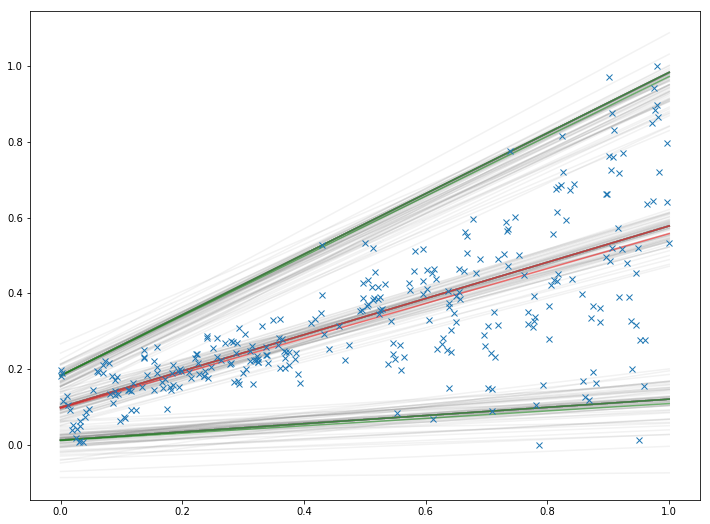

In [83]:
plt.figure(figsize=(12, 9))
n = 100
n_c = 2
median_i = int(QUANTILES.shape[0]/2)

plt.plot(x_, y_hat[:, 0, :n], c='grey', alpha=.1)
plt.plot(x_, y_hat[:, median_i, :n], c='grey', alpha=.1)
plt.plot(x_, y_hat[:, -1, :n], c='grey', alpha=.1)
plt.plot(x_, y_hat[:, 0, n:n+n_c], c='green', alpha=.5)
plt.plot(x_, y_hat[:, median_i, n:n+n_c], c='red', alpha=.5)
plt.plot(x_, y_hat[:, -1, n:n+n_c], c='green', alpha=.5)

plt.plot(x, y, 'x')
plt.show();

## Comparing the outcome of the two methods

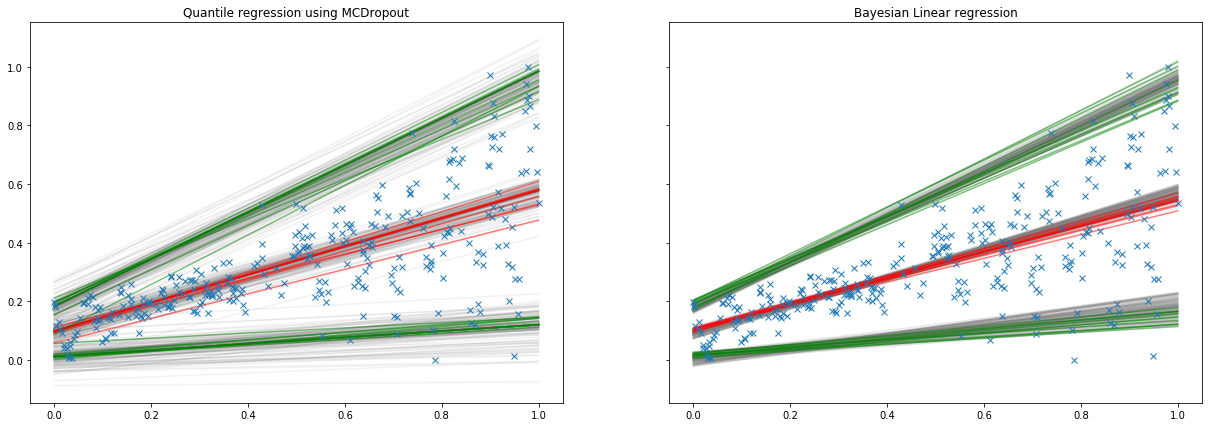

In [84]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(21,7))
n = 200
n_c = 10

axes[0].plot(x_, y_hat[:, 0, :n], c='grey', alpha=.1)
axes[0].plot(x_, y_hat[:, 2, :n], c='grey', alpha=.1)
axes[0].plot(x_, y_hat[:, 4, :n], c='grey', alpha=.1)
axes[0].plot(x_, y_hat[:, 0, n:n+n_c], c='green', alpha=.5)
axes[0].plot(x_, y_hat[:, 2, n:n+n_c], c='red', alpha=.5)
axes[0].plot(x_, y_hat[:, 4, n:n+n_c], c='green', alpha=.5)
axes[0].plot(x, y, 'x')
axes[0].set_title('Quantile regression using MCDropout')

axes[1].plot(x_, (trace['alpha'][:n] + trace['beta'][:n] * x_), alpha=.1, c='grey')
axes[1].plot(x_, std_2_min[:, :n], alpha=.1, c='grey')
axes[1].plot(x_, std_2_plus[:, :n], alpha=.1, c='grey')
axes[1].plot(x_, (trace['alpha'][n:n+n_c] + trace['beta'][n:n+n_c] * x_), alpha=.5, c='red')
axes[1].plot(x_, std_2_min[:, n:n+n_c], alpha=.5, c='green')
axes[1].plot(x_, std_2_plus[:, n:n+n_c], alpha=.5, c='green')
axes[1].plot(x, y, 'x')
axes[1].set_title('Bayesian Linear regression');

## Averaging
When taking the mean of the samples, the result is quite close...

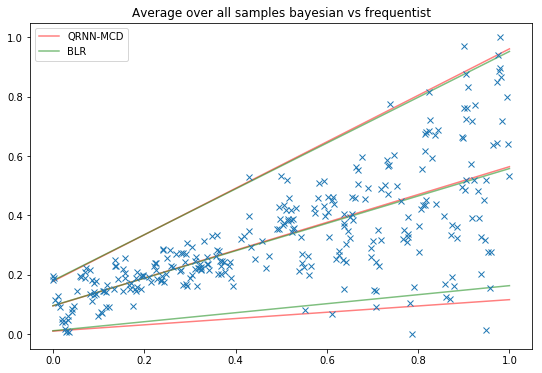

In [87]:
fig = plt.figure(figsize=(9,6))

plt.plot(x_, np.mean(y_hat[:, 0, :], axis=-1), c='red', alpha=.5)
plt.plot(x_, np.mean(y_hat[:, 2, :], axis=-1), c='red', alpha=.5, label="QRNN-MCD")
plt.plot(x_, np.mean(y_hat[:, 4, :], axis=-1), c='red', alpha=.5)
plt.plot(x_, np.mean(trace['alpha']) + np.mean(trace['beta']) * x_, alpha=.5, c='green', label="BLR")
plt.plot(x_, np.mean(std_2_min, axis=1), alpha=.5, c='green')
plt.plot(x_, np.mean(std_2_plus, axis=1), alpha=.5, c='green')
plt.plot(x, y, 'x')
plt.title('Average over all samples bayesian vs frequentist')
plt.legend();